In [60]:
import numpy as np
import pandas as pd
import json

import seaborn as sns
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = (25,10)
mpl.rcParams['axes.grid'] = False
np.random.seed(0)

In [106]:
columns = [ 'timestamp', 'heart_rate', 'steps', 'stress_score',
            'awake', 'deep', 'light', 'rem', 
           'nonrem_total', 'total', 'nonrem_percentage', 'sleep_efficiency']

# Include FonLog data
# columns += ['time_from_last_drug_taken'] #, 'wo_duration']

# Additional data
columns += ['timestamp_dayofweek', 'timestamp_hour_sin', 'timestamp_hour_cos']

# 'wearing_off' | 'wearing_off_post_meds' | 'wearing_off_lead60'
target_column = 'wearing_off' 
columns.append(target_column)

participant_dictionary = json.load(open(f'./data/participant_dictionary.json'))

# CV splits
if interval == '15min':
    record_size_per_day = 96
elif interval == '15s':
    record_size_per_day = 5760
elif interval == '1min':
    record_size_per_day = 1440

In [110]:
def load_dataset(user, interval):
    dataset = pd.read_excel(f'./data/4-combined_data_{user}_{interval}.xlsx',
                                  index_col="timestamp",
                                  usecols=columns,
                                  engine='openpyxl')
    # Fill missing data with 0
    dataset.fillna(0, inplace=True)

    # Filter data based on participants' dictionary
    dataset = dataset.loc[
        (dataset.index >= participant_dictionary[user]['start_date']) &
        (dataset.index < participant_dictionary[user]['end_date_plus_two'])
    ]

    column_indices = { name: i for i, name in enumerate(dataset.columns) }
    df = dataset
    return dataset

# Visualization

In [253]:
def visualize_wearing_offs(df, user):
    # Fix timestamp format
    date_time = pd.to_datetime(df.index, format='%d.%m.%Y %H:%M:%S')
    
    # plot_cols = df.columns
    plot_cols = ['heart_rate', 'wearing_off']
    plot_features = df[plot_cols]
    plot_features.index = date_time
    i = 1
    # plot each column
    plt.figure(figsize=(25,10))
    for group in plot_cols:
        if group == 'wearing_off':
            continue
        ax = plt.subplot(len(plot_cols), 1, i)
        plt.fill_between(
            plot_features.index, 0, plot_features.loc[:, [group]].max(), where=plot_features.wearing_off, alpha=0.4, color="red", transform=ax.get_xaxis_transform()
        )
        plt.plot(plot_features.loc[:, [group]])
        plt.title(group, y=0.5, loc='right')
        i += 1
    plt.suptitle(f'Input features with wearing-off periods for Participant {user}')
    plt.show()

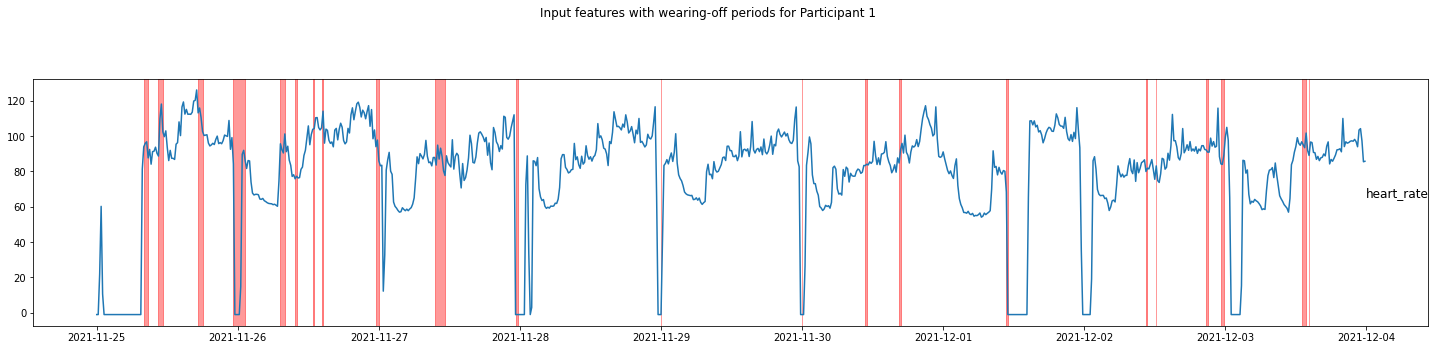

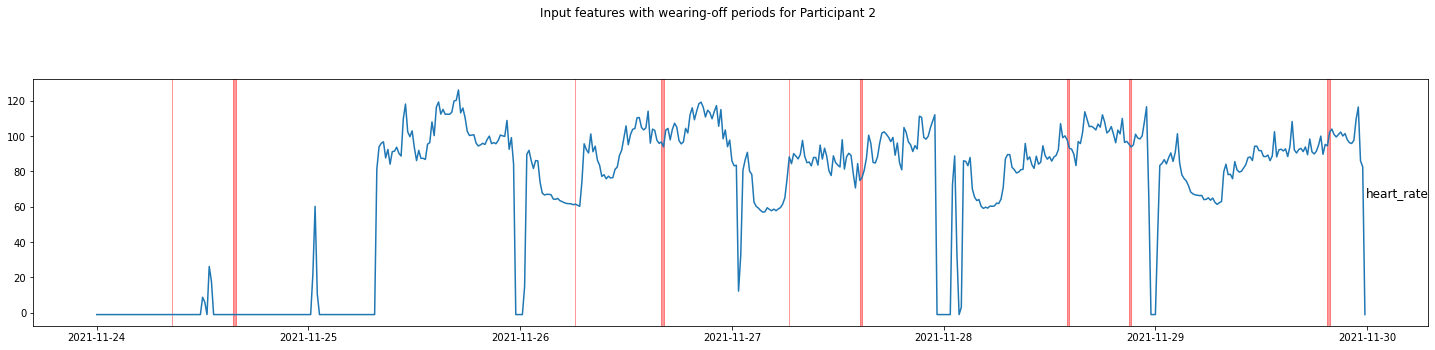

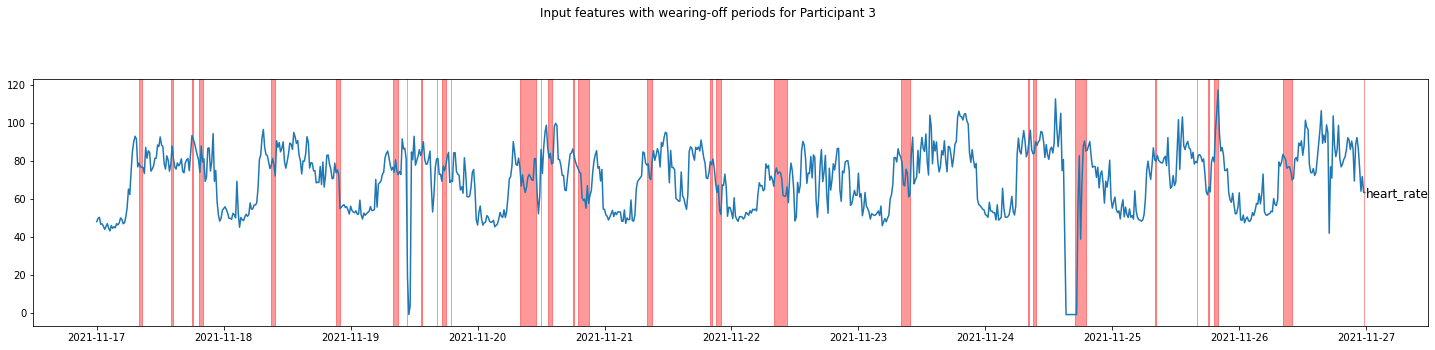

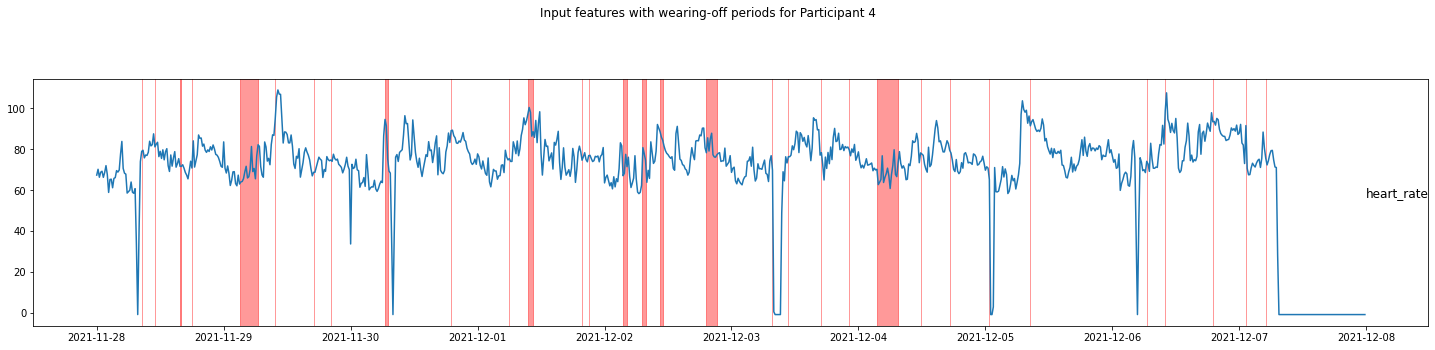

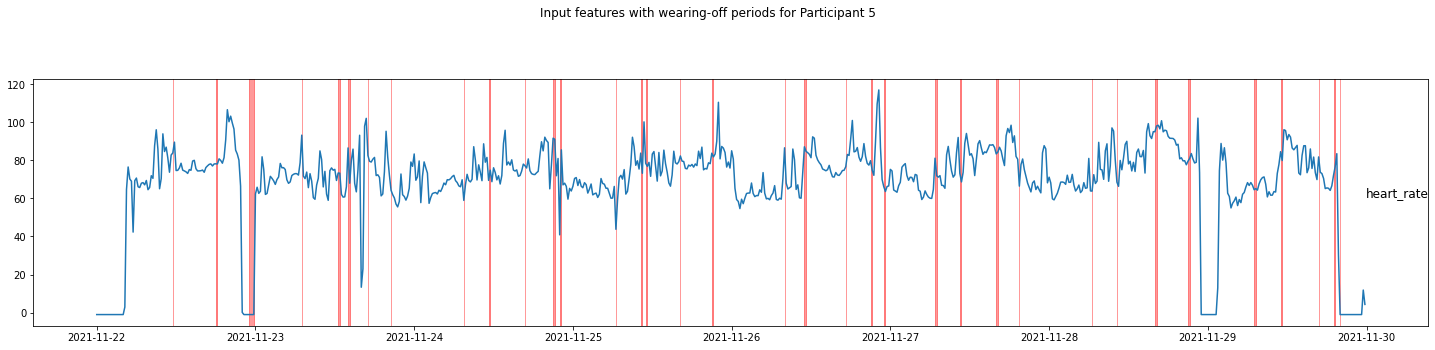

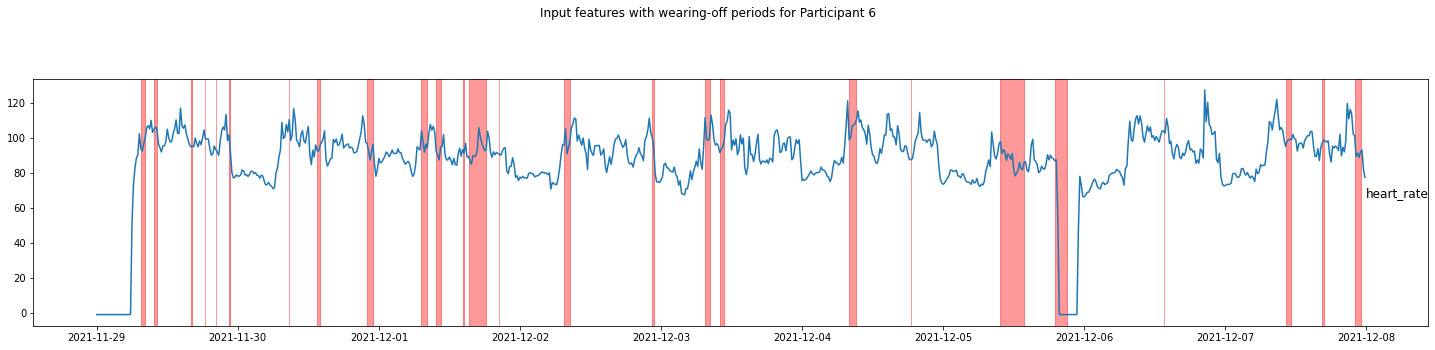

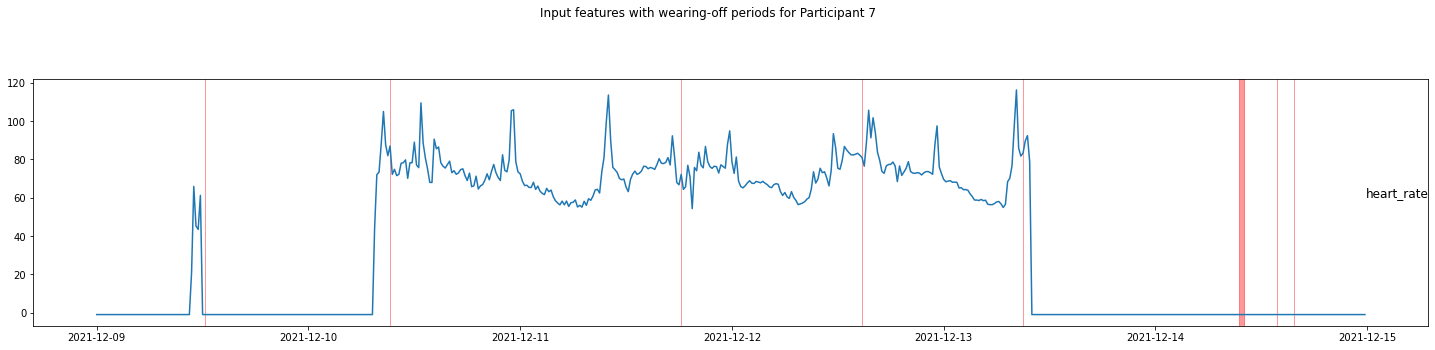

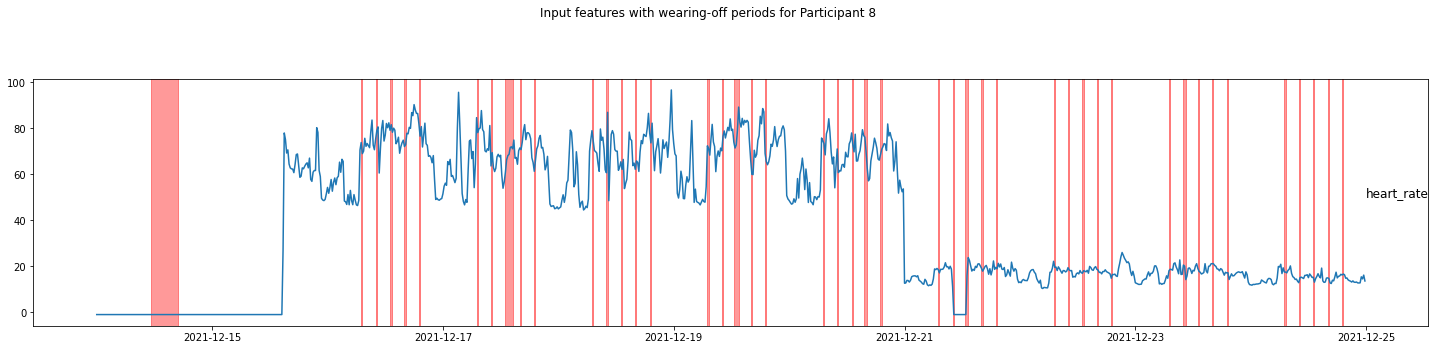

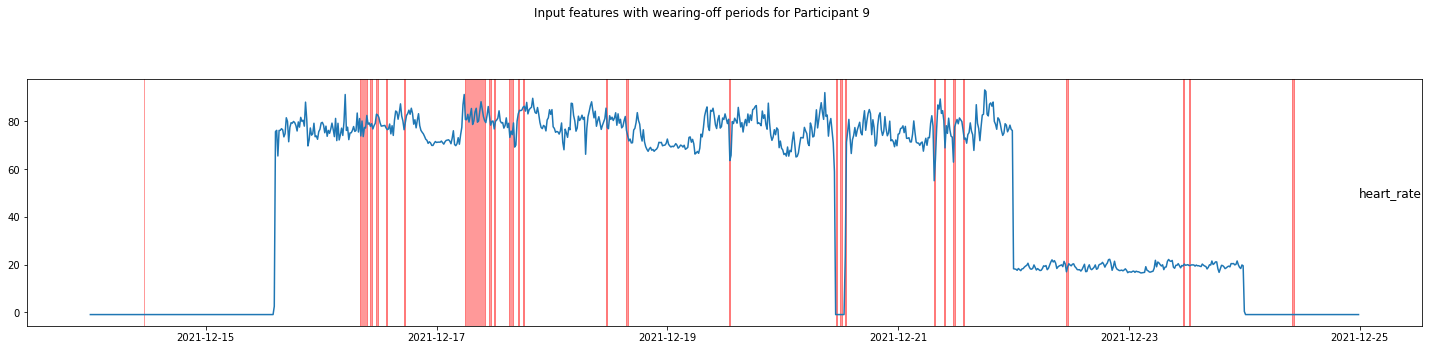

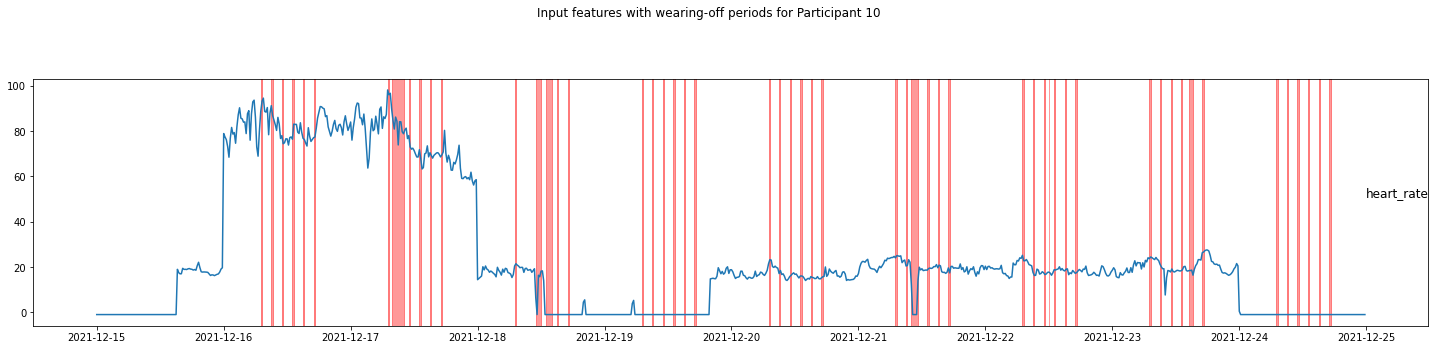

In [255]:
for number in range(1, 11):
    dataset = load_dataset(f'participant{number}', interval)

    visualize_wearing_offs(dataset, number)

# Correlation

In [109]:
from scipy import stats
def ignore_nans(a,b):
    index = ~a.isnull() & ~b.isnull()
    return a[index], b[index]

In [132]:
correlations = None
for number in range(1, 11):
    dataset = load_dataset(f'participant{number}', interval)
        
    participant = {}
    for variable in columns[1:-1]:
        r_value, p_value = stats.pearsonr(
            *ignore_nans(dataset.wearing_off, dataset[variable])
        )
        participant[variable] = {}
        participant[variable][f'r_value_{number}'] = r_value
        participant[variable][f'p_value_{number}'] = p_value
    
    if correlations is None:
        correlations = pd.DataFrame(participant).T
    else:
        correlations = pd.concat([correlations, pd.DataFrame(participant).T], axis=1)

In [133]:
correlations

,r_value_1,p_value_1,r_value_2,p_value_2,r_value_3,p_value_3,r_value_4,p_value_4,r_value_5,p_value_5,r_value_6,p_value_6,r_value_7,p_value_7,r_value_8,p_value_8,r_value_9,p_value_9,r_value_10,p_value_10
heart_rate,-0.016919,0.619454,0.016588,0.691159,0.072489,2.470189e-02,0.089112,5.728358e-03,0.007738,0.830464,0.035095,3.028247e-01,-0.020398,0.625161,0.016594,5.901294e-01,0.139388,5.456761e-06,0.049837,1.228078e-01
steps,-0.050444,0.138466,-0.021041,0.614294,-0.071094,2.761650e-02,-0.004670,8.851113e-01,-0.038313,0.288958,-0.038816,2.543984e-01,0.032853,0.431294,0.126340,3.835014e-05,0.041785,1.748352e-01,0.013856,6.680825e-01
stress_score,0.039182,0.249948,0.022876,0.583757,0.184476,8.520879e-09,0.057923,7.284014e-02,0.093145,0.009803,0.092631,6.436062e-03,0.020313,0.626616,0.060806,4.821618e-02,0.034443,2.634453e-01,0.044035,1.728032e-01
awake,-0.119329,0.000440,0.045388,0.276817,-0.056105,8.230957e-02,-0.018319,5.707748e-01,0.010888,0.763227,0.048984,1.502633e-01,-0.039341,0.345935,0.016191,5.991938e-01,-0.093342,2.395131e-03,0.032570,3.134113e-01
deep,-0.115797,0.000649,0.009978,0.811146,0.065157,4.355816e-02,0.149725,3.172655e-06,0.003463,0.923668,0.017424,6.090321e-01,-0.050543,0.225833,-0.025287,4.117042e-01,0.191770,3.325157e-10,0.006678,8.362863e-01
light,-0.020154,0.554104,0.051257,0.219333,-0.074405,2.113583e-02,-0.028152,3.835971e-01,0.013870,0.701157,-0.008061,8.129568e-01,-0.052596,0.207514,0.011128,7.179396e-01,0.077512,1.174749e-02,0.030804,3.403845e-01
rem,-0.072268,0.033676,0.024874,0.551322,-0.032380,3.162405e-01,-0.068660,3.341350e-02,0.001717,0.962120,-0.097336,4.186660e-03,-0.051720,0.215192,0.013828,6.535403e-01,-0.032431,2.923788e-01,0.027739,3.906065e-01
nonrem_total,-0.098976,0.003589,0.049409,0.236427,-0.068481,3.387605e-02,0.014525,6.530824e-01,0.011301,0.754519,0.004118,9.037995e-01,-0.052573,0.207716,0.004281,8.894977e-01,0.154493,4.539967e-07,0.027736,3.906688e-01
total,-0.108234,0.001442,0.048449,0.245669,-0.084402,8.887282e-03,0.000179,9.955701e-01,0.010640,0.768461,-0.006189,8.558449e-01,-0.052828,0.205515,0.006956,8.213642e-01,0.136713,8.260299e-06,0.032171,3.193765e-01
nonrem_percentage,-0.103610,0.002294,0.047533,0.254719,-0.010352,7.487065e-01,0.057619,7.435543e-02,0.006063,0.866789,-0.005923,8.619828e-01,-0.053145,0.202804,-0.007720,8.021465e-01,0.042354,1.690316e-01,0.022140,4.932348e-01


# Season & Trend
[Reference](https://medium.com/analytics-vidhya/interpreting-acf-or-auto-correlation-plot-d12e9051cd14)

In [54]:
from numpy import polyfit

def fit(X, y, degree=3):
    coef = polyfit(X, y, degree)
    trendpoly = np.poly1d(coef)
    return trendpoly(X)

def get_season(s, yearly_periods=4, degree=3):
    X = [i % (365/4) for i in range(0, len(s))]
    seasonal = fit(X, s.values, degree)
    return pd.Series(data=seasonal, index=s.index)

def get_trend(s, degree=3):
    X = list(range(len(s)))
    trend = fit(X, s.values, degree)
    return pd.Series(data=trend, index=s.index)

for number in range(1, 11):
    dataset = load_dataset(f'participant{number}', interval)

    tmp = dataset.loc[:, ['wearing_off']]
    tmp['trend'] = get_trend(dataset['wearing_off'])
    tmp['season'] = get_season(dataset['wearing_off']) - tmp['trend']
    sns.lineplot(data=tmp[['wearing_off', 'season', 'trend']])
    plt.ylabel('wearing_off')
    plt.show()

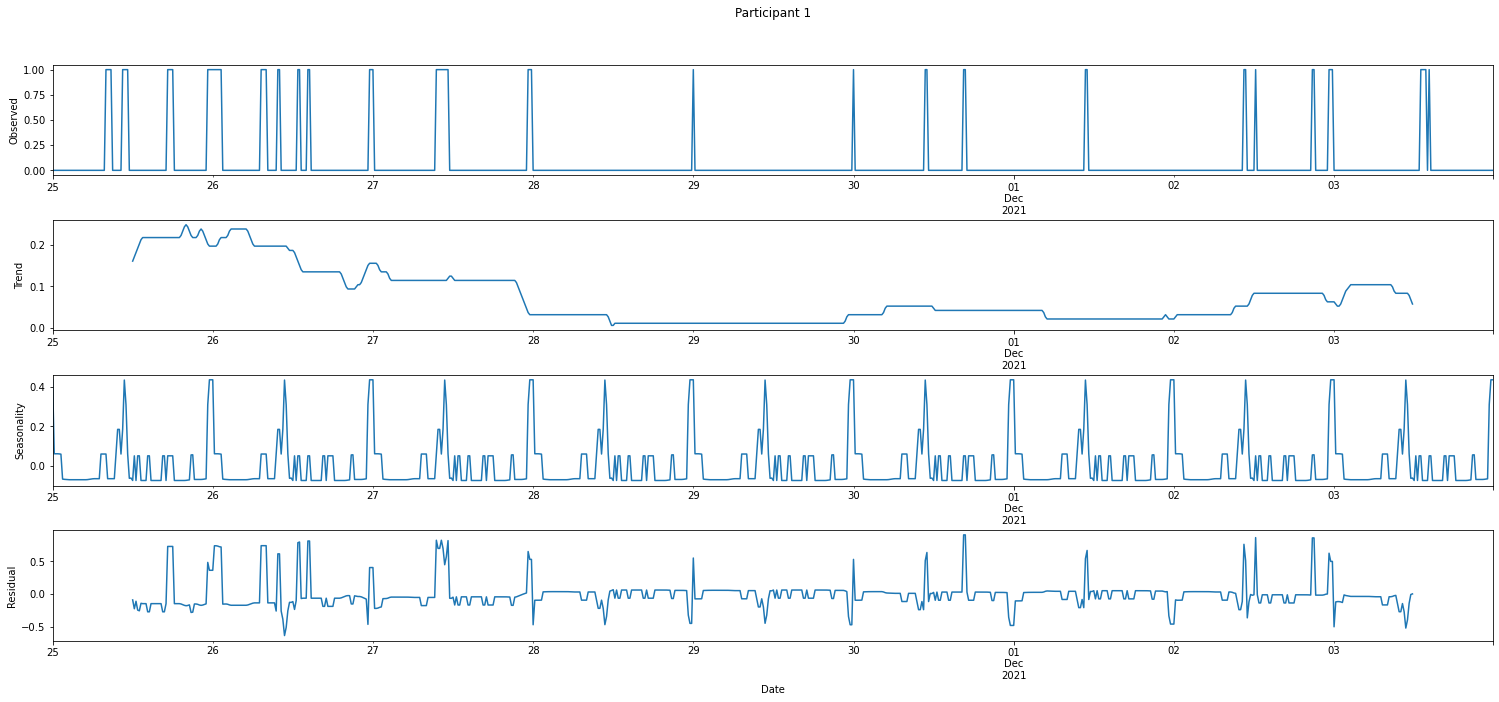

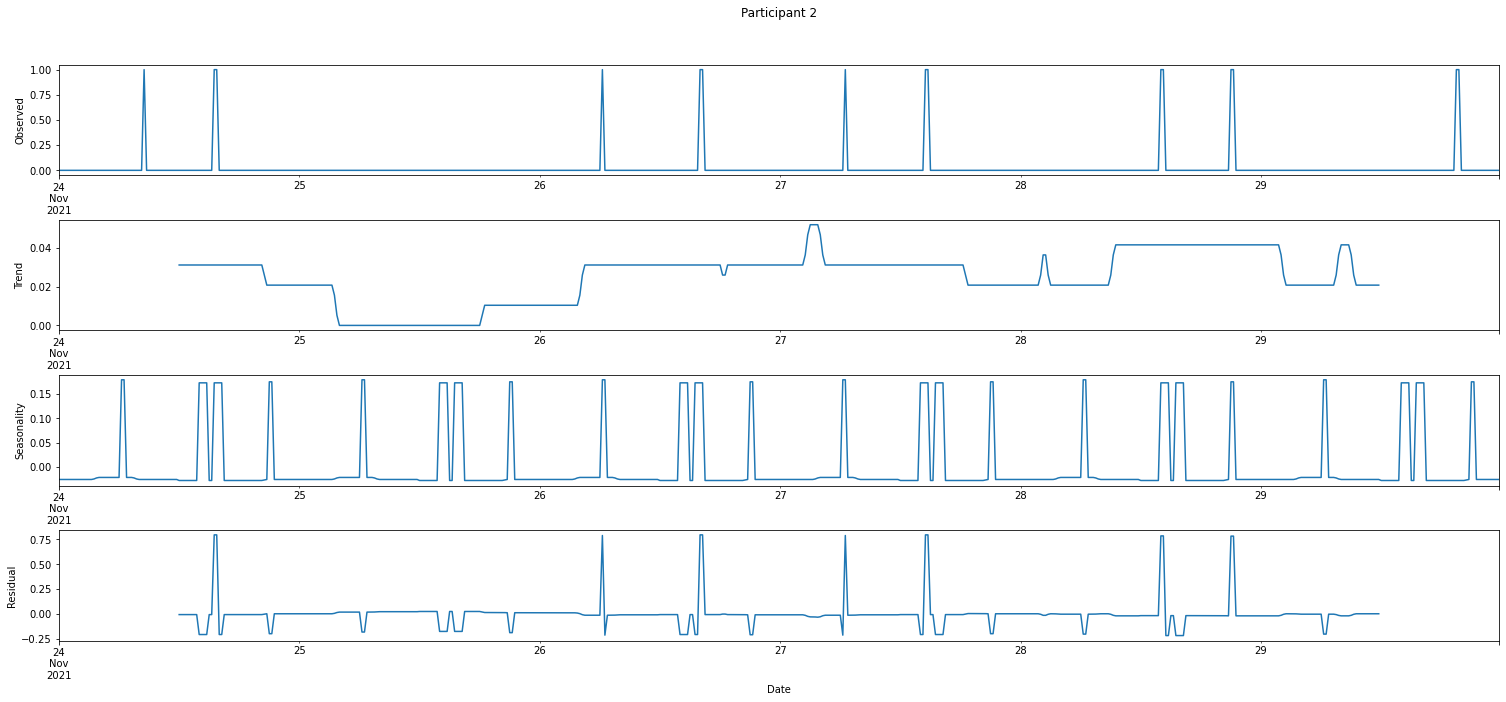

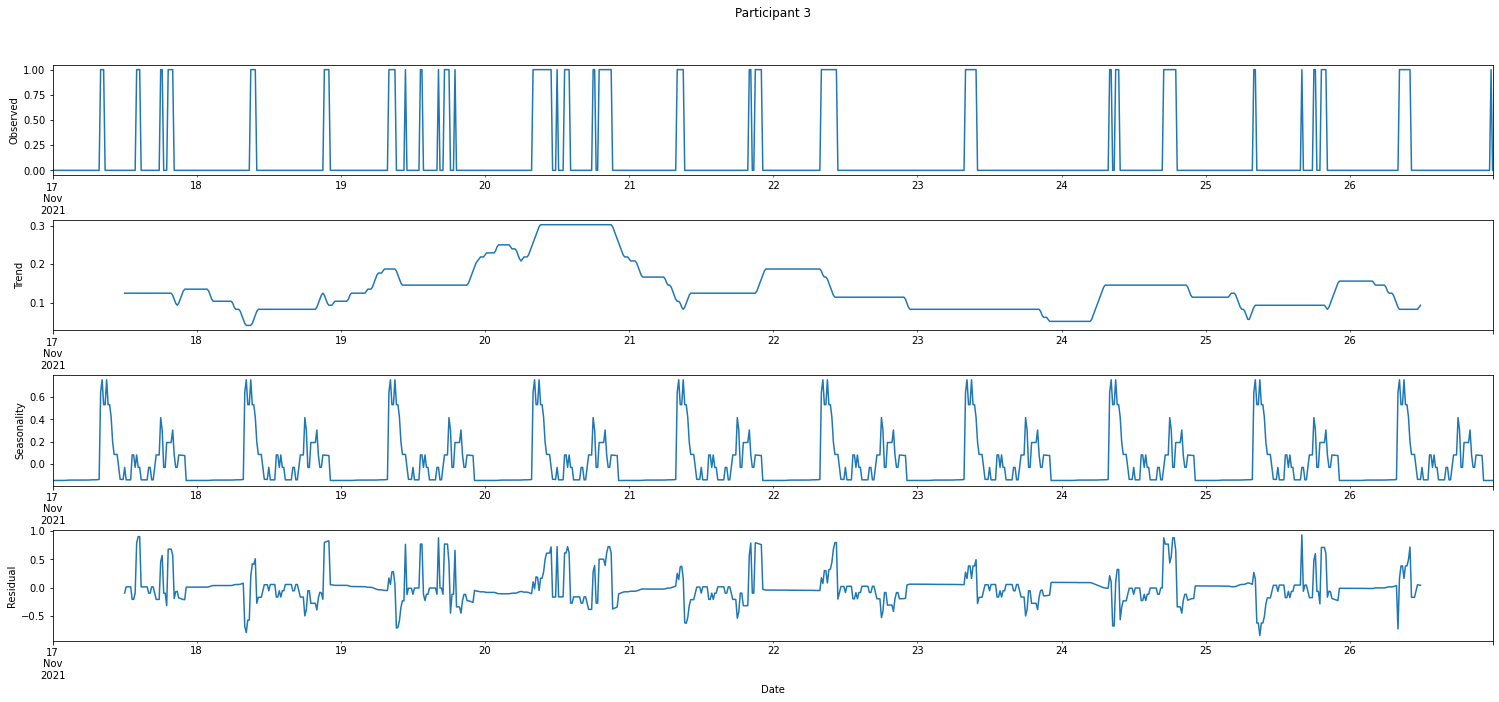

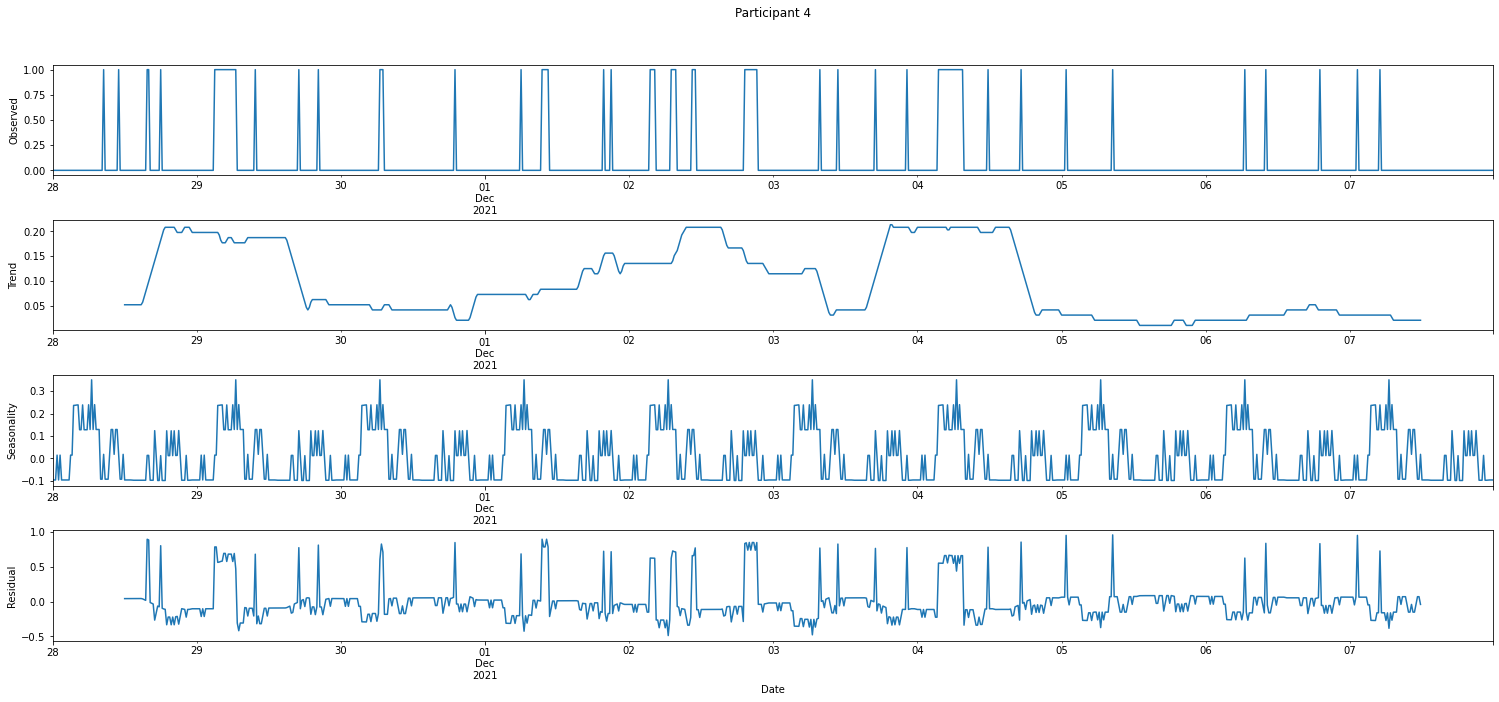

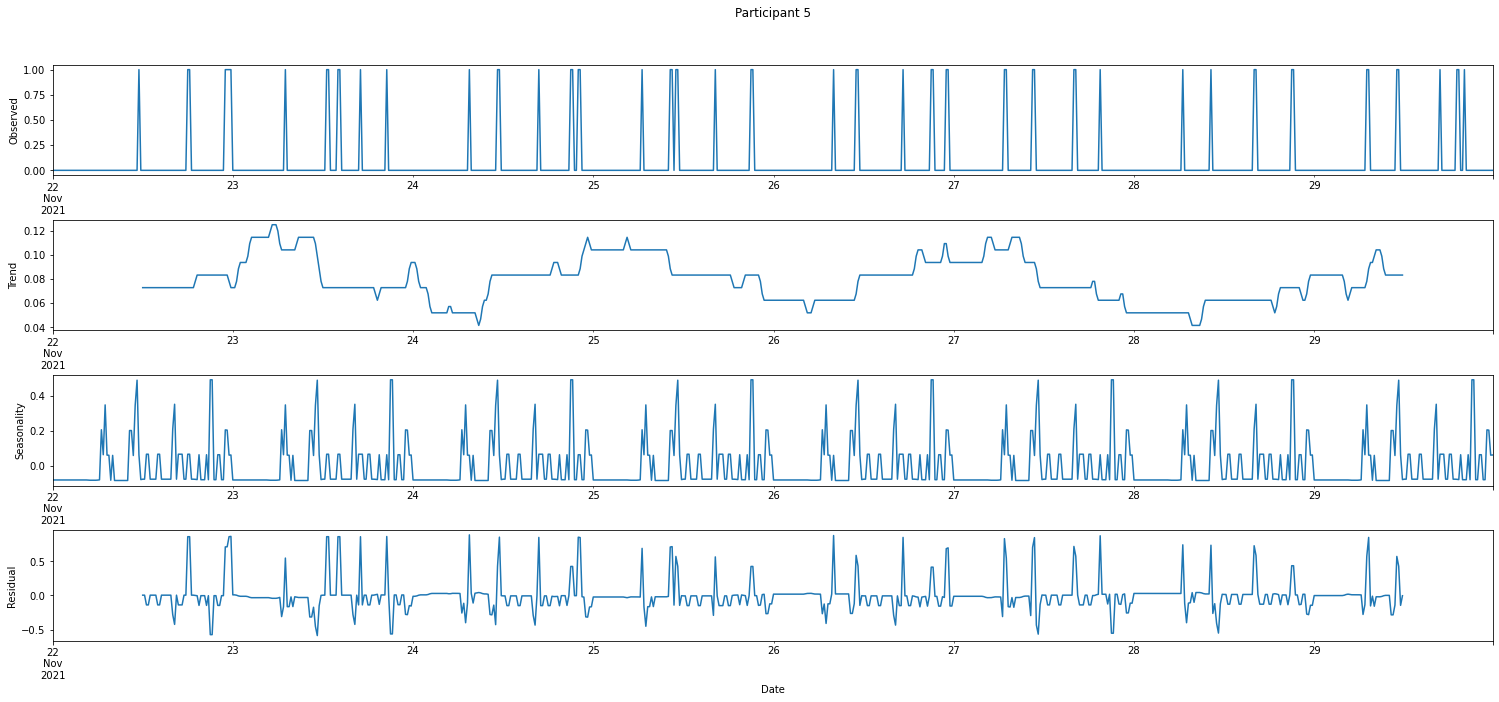

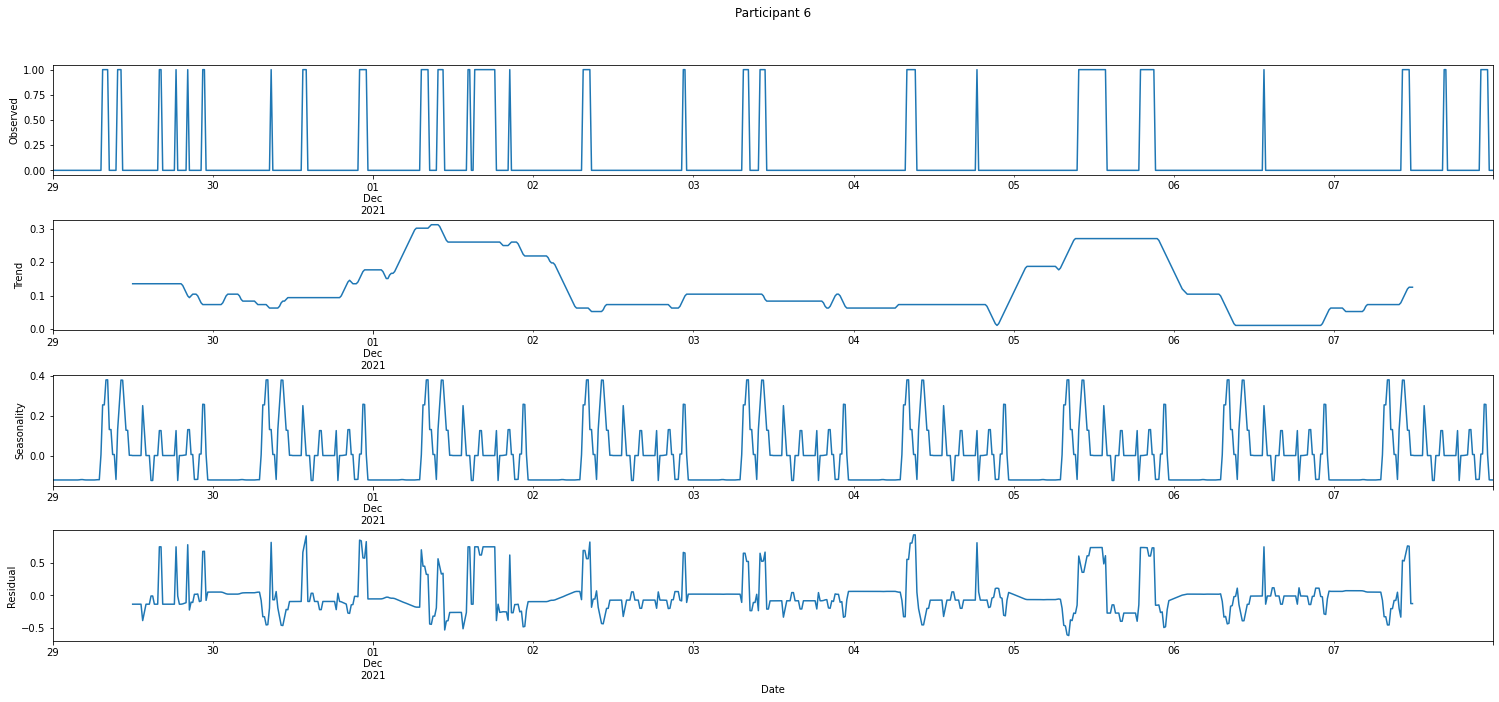

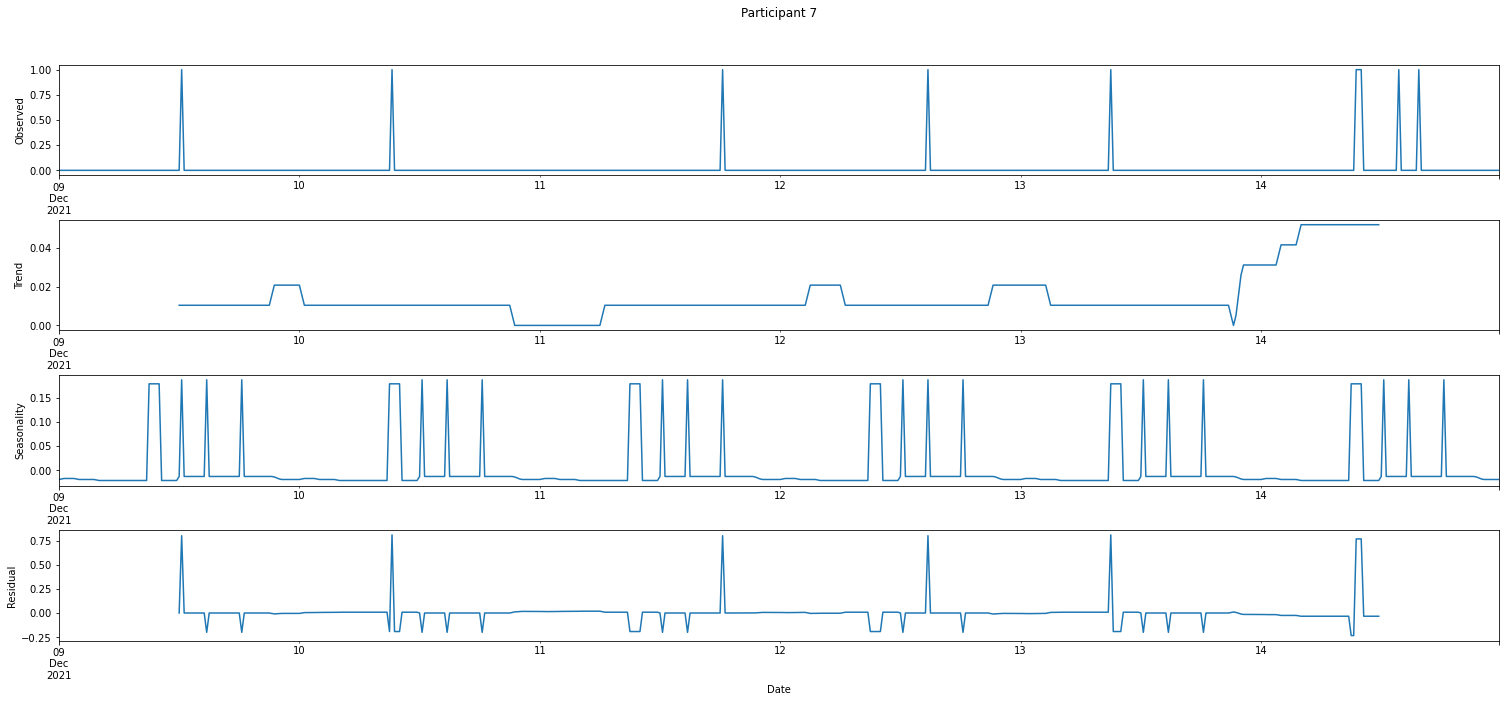

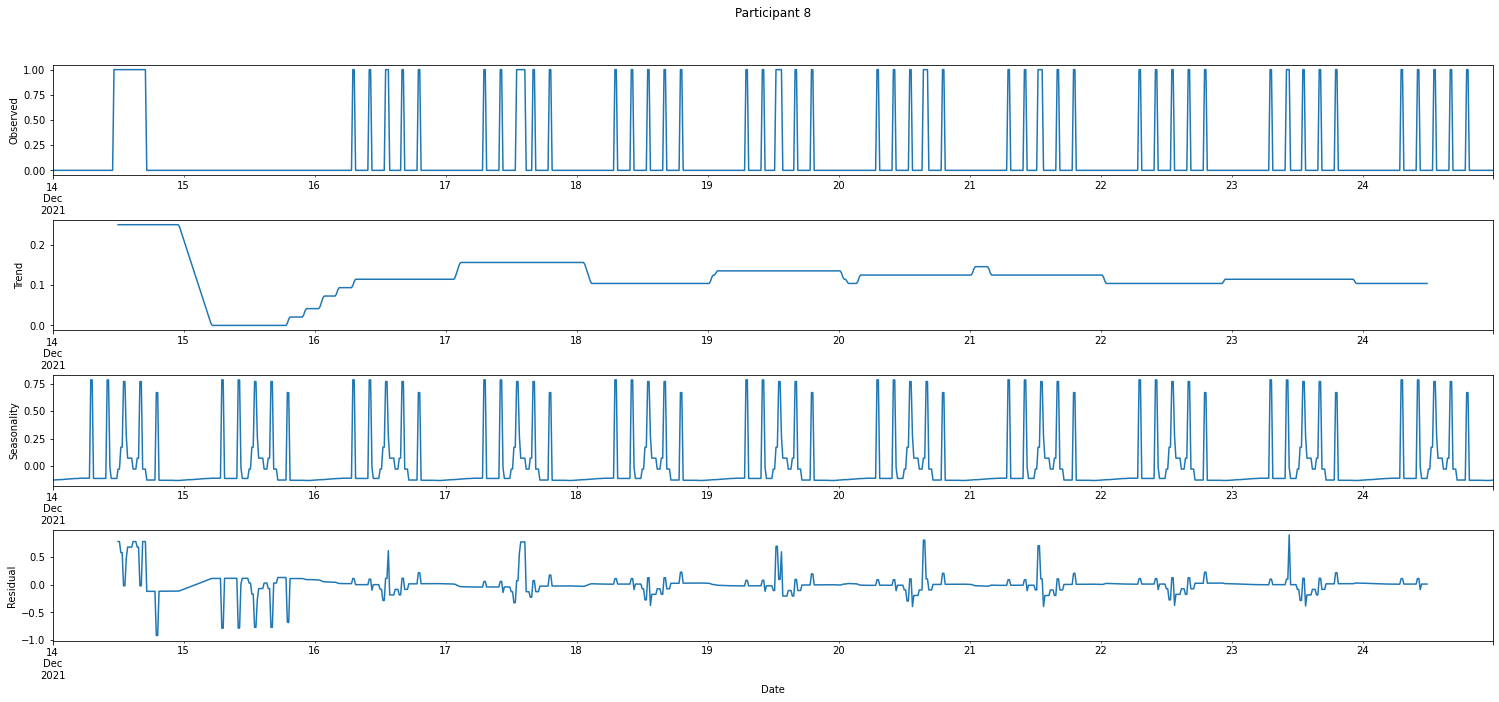

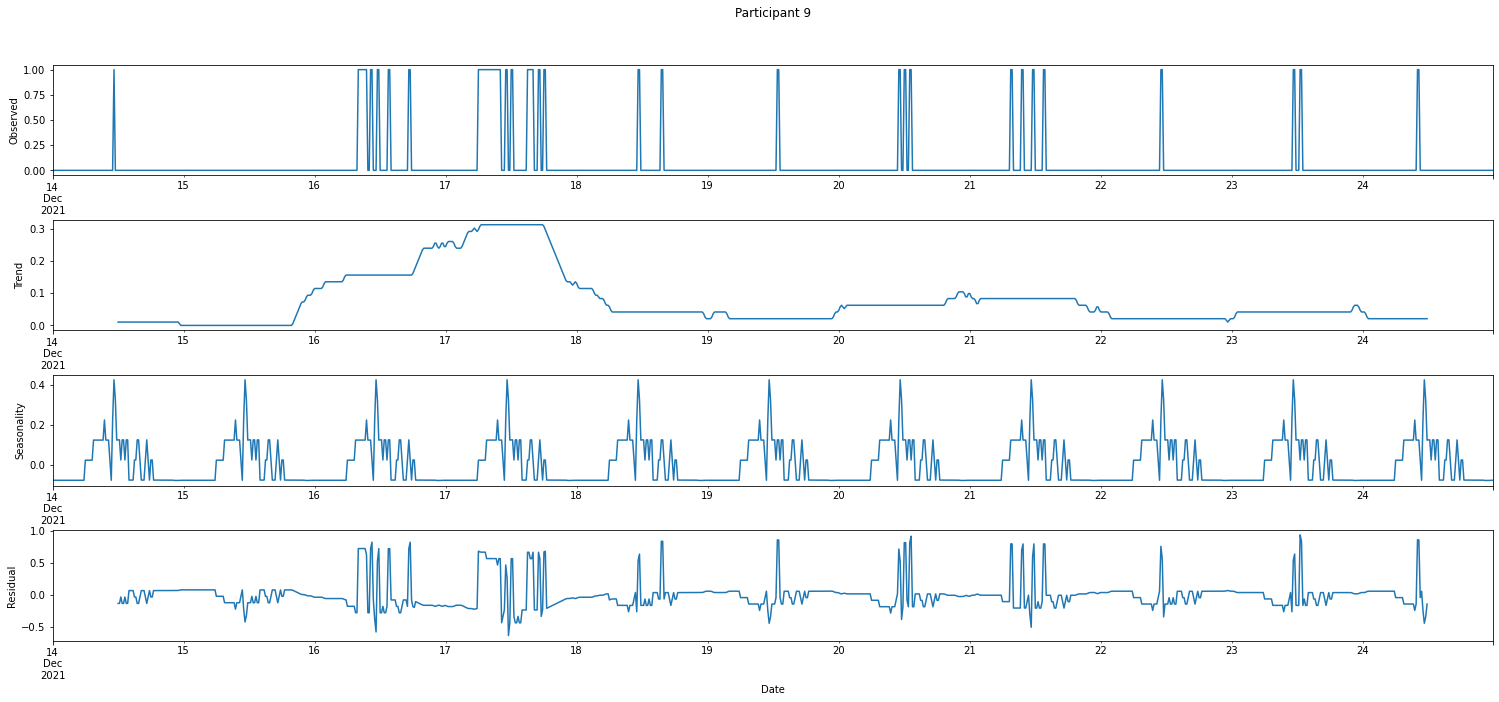

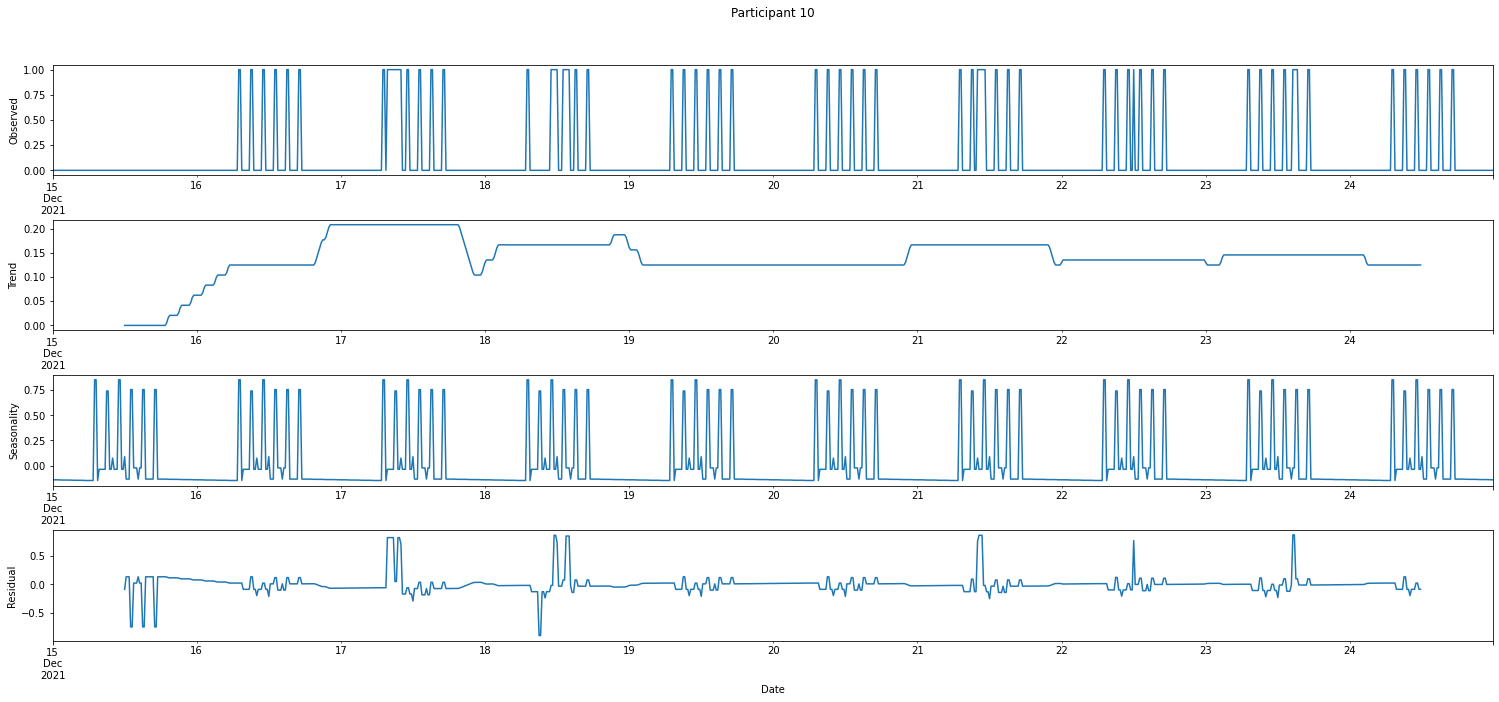

In [258]:
from statsmodels.tsa.seasonal import seasonal_decompose

def plot_trend(dataset, user):
    res = seasonal_decompose(dataset.wearing_off, model = "additive", period=96)

    fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1)
    res.observed.plot(ax=ax1,ylabel = "Observed")
    res.trend.plot(ax=ax2,ylabel = "Trend")
    res.seasonal.plot(ax=ax3,ylabel = "Seasonality")
    res.resid.plot(ax=ax4,ylabel = "Residual")

    fig.suptitle(f'Participant {user}')
    ax4.set_xlabel("Date")
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
    plt.show()
    
for number in range(1, 11):
    dataset = load_dataset(f'participant{number}', interval)

    plot_trend(dataset, number)

# Autocorrelation

stationary


/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


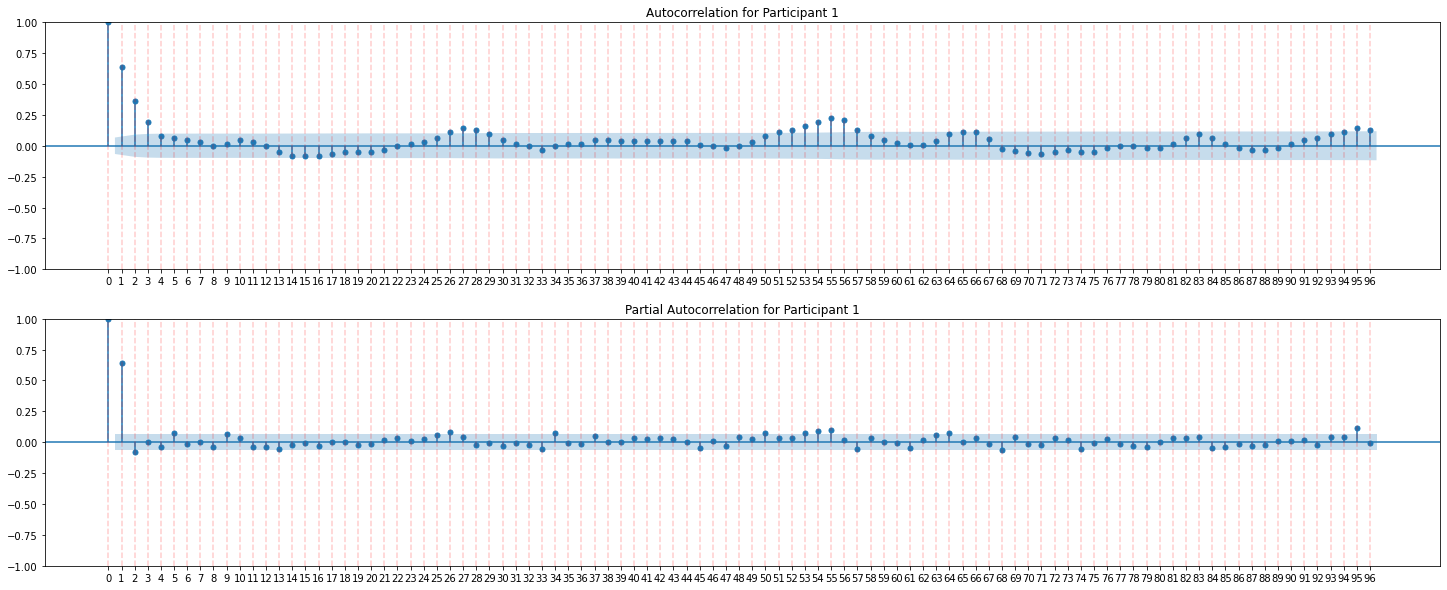

stationary


/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


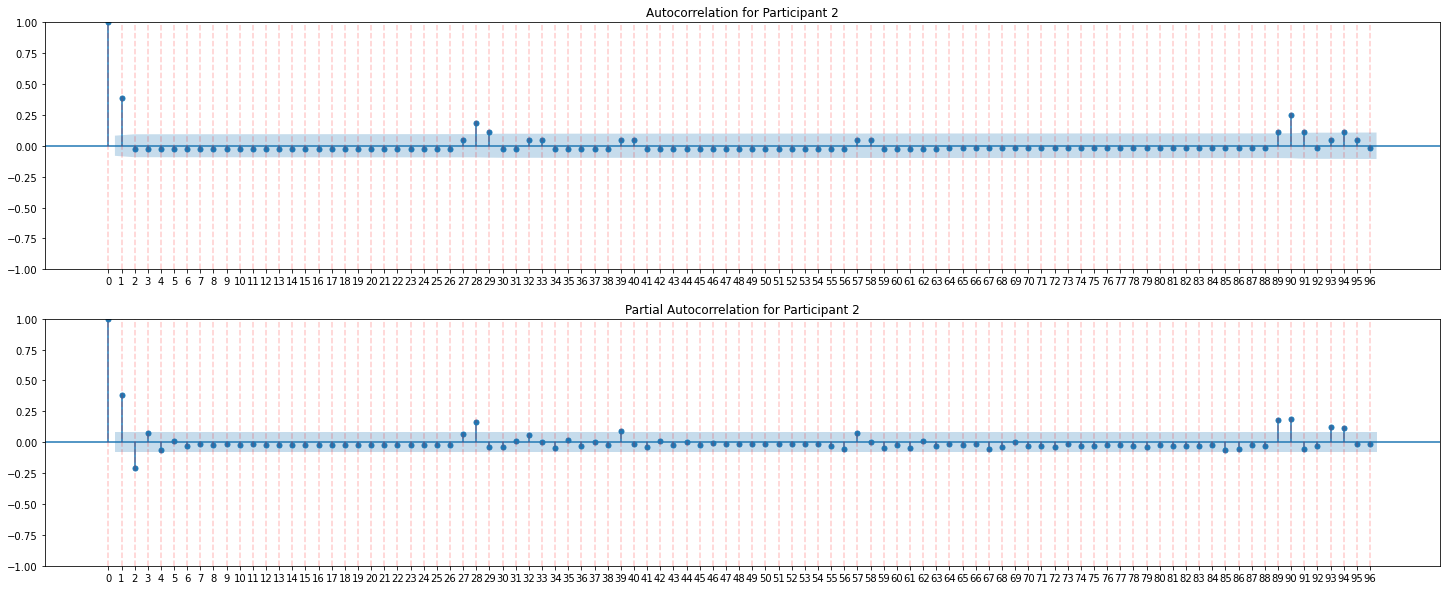

stationary


/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


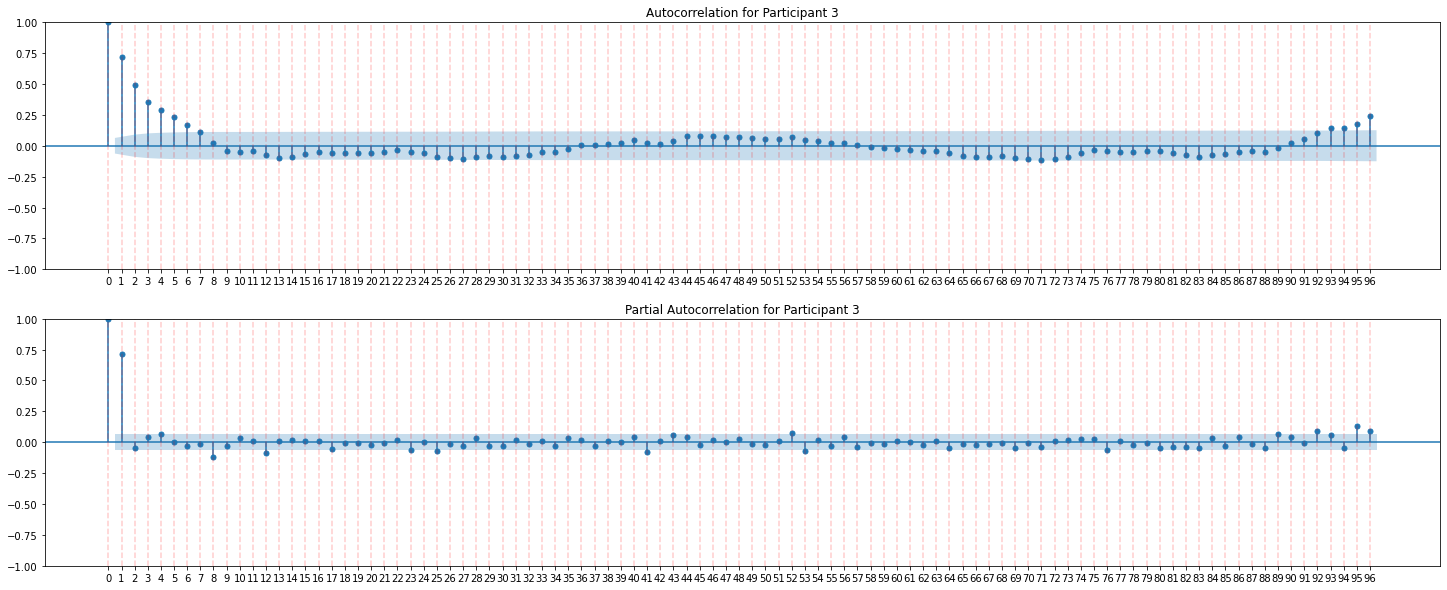

stationary


/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


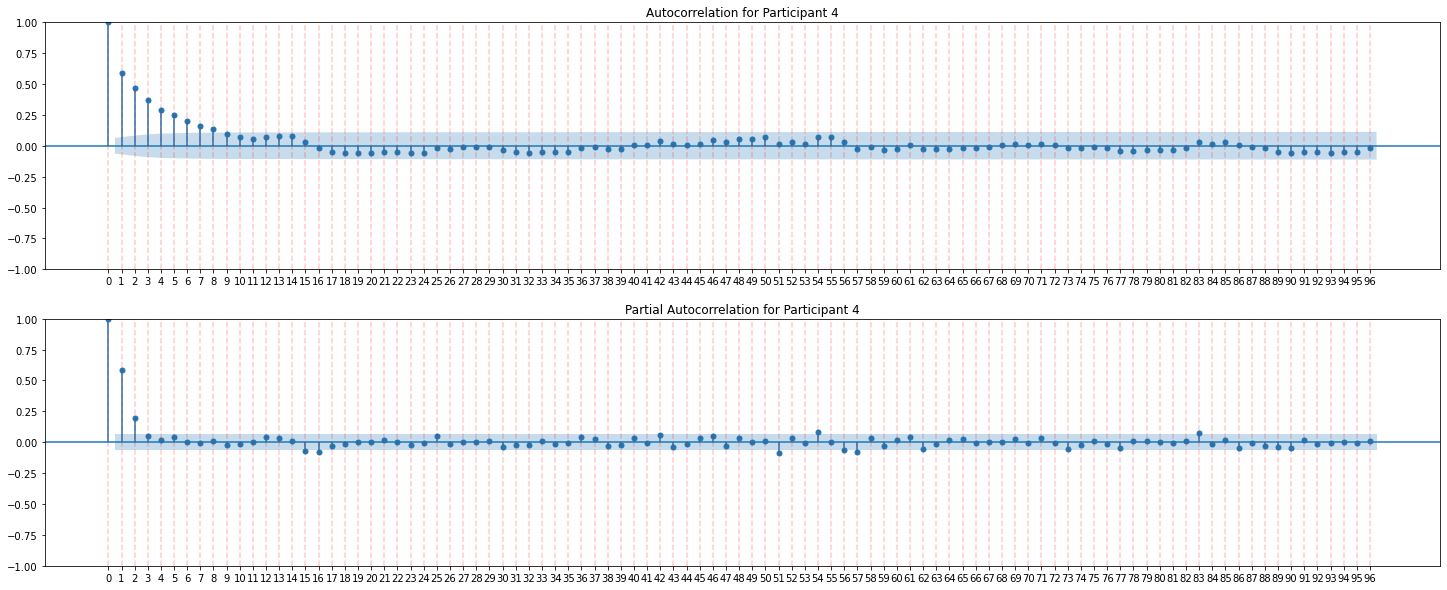

stationary


/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


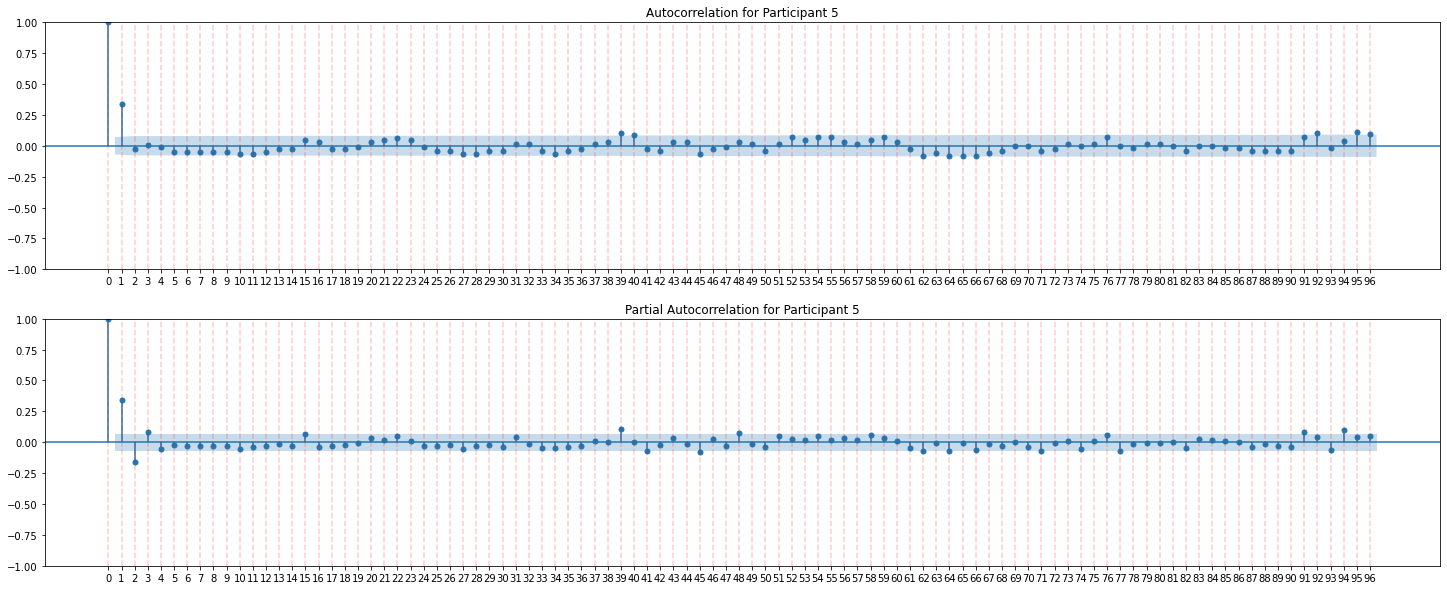

stationary


/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


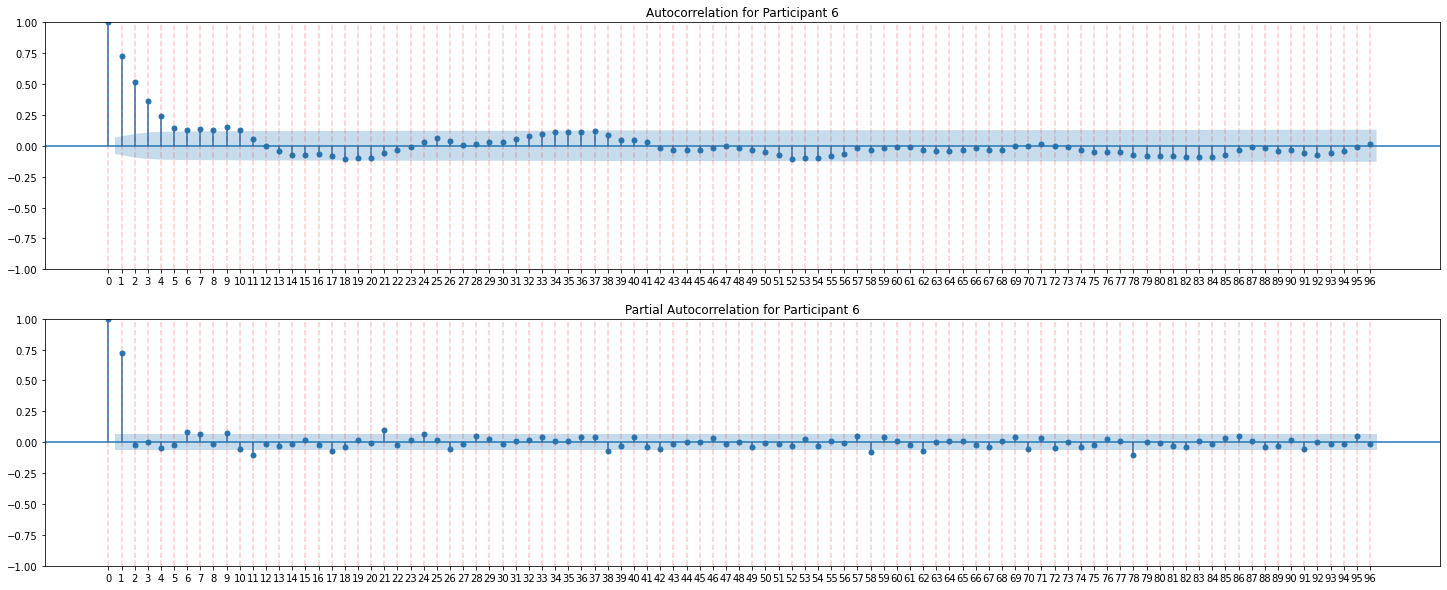

stationary


/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


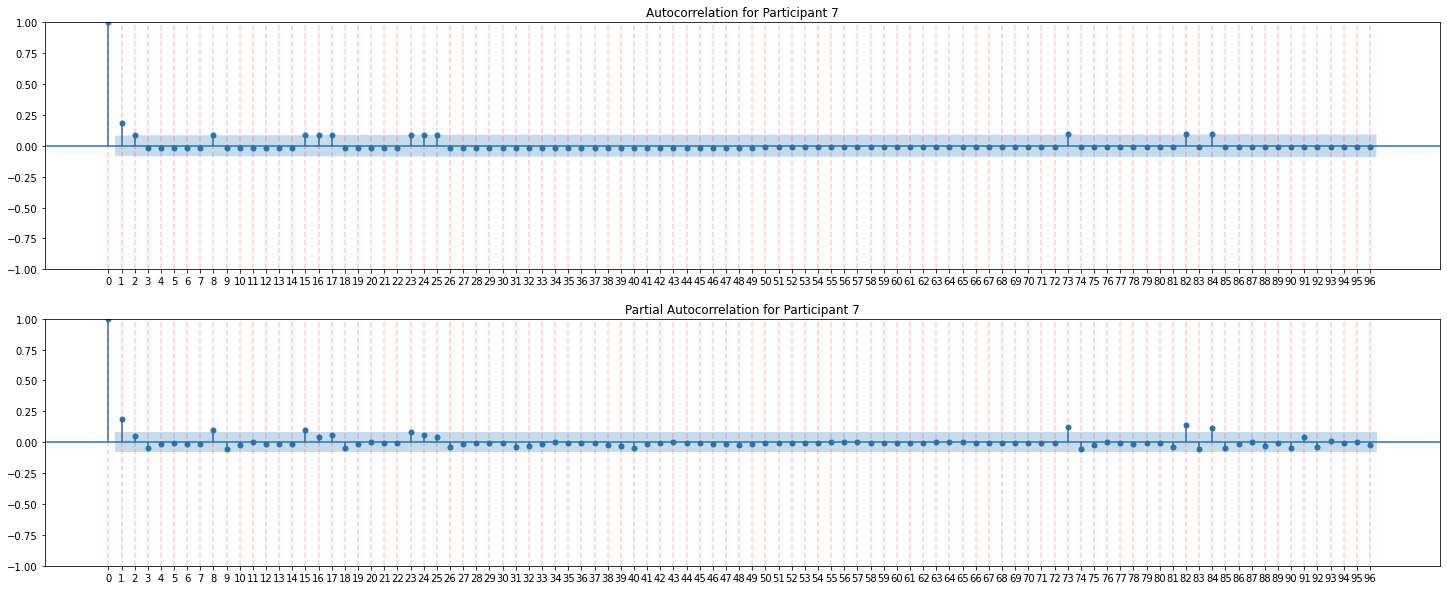

stationary


/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


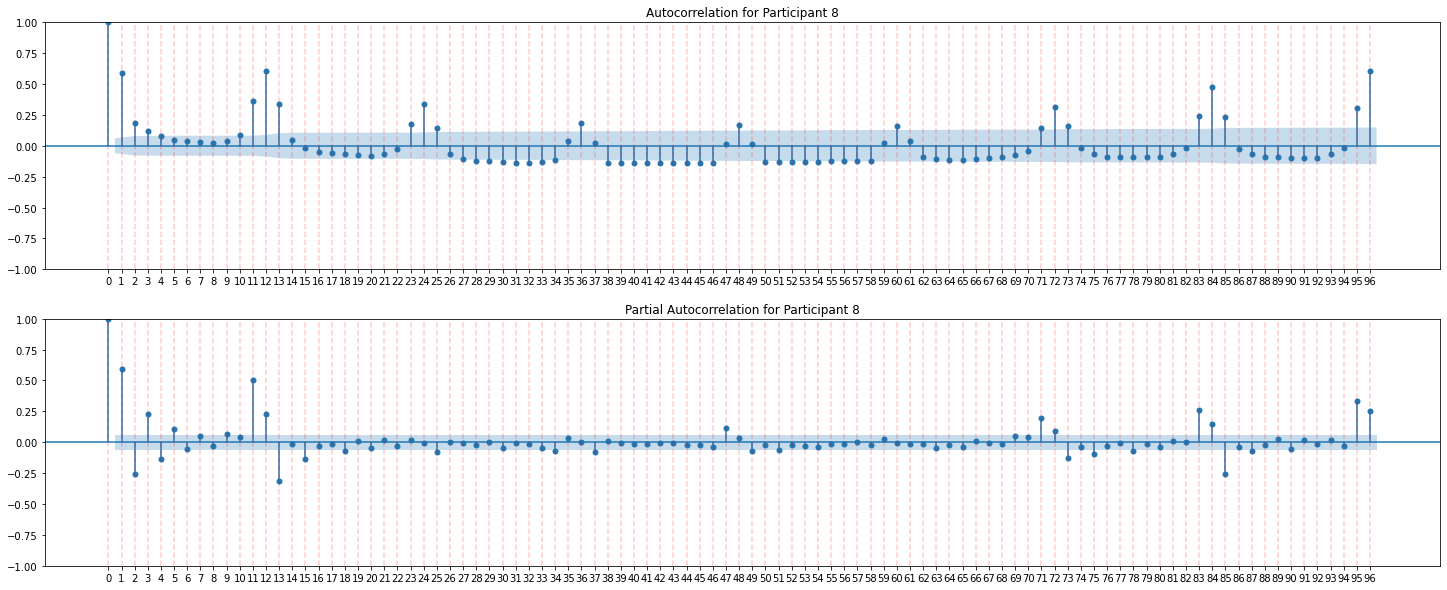

stationary


/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


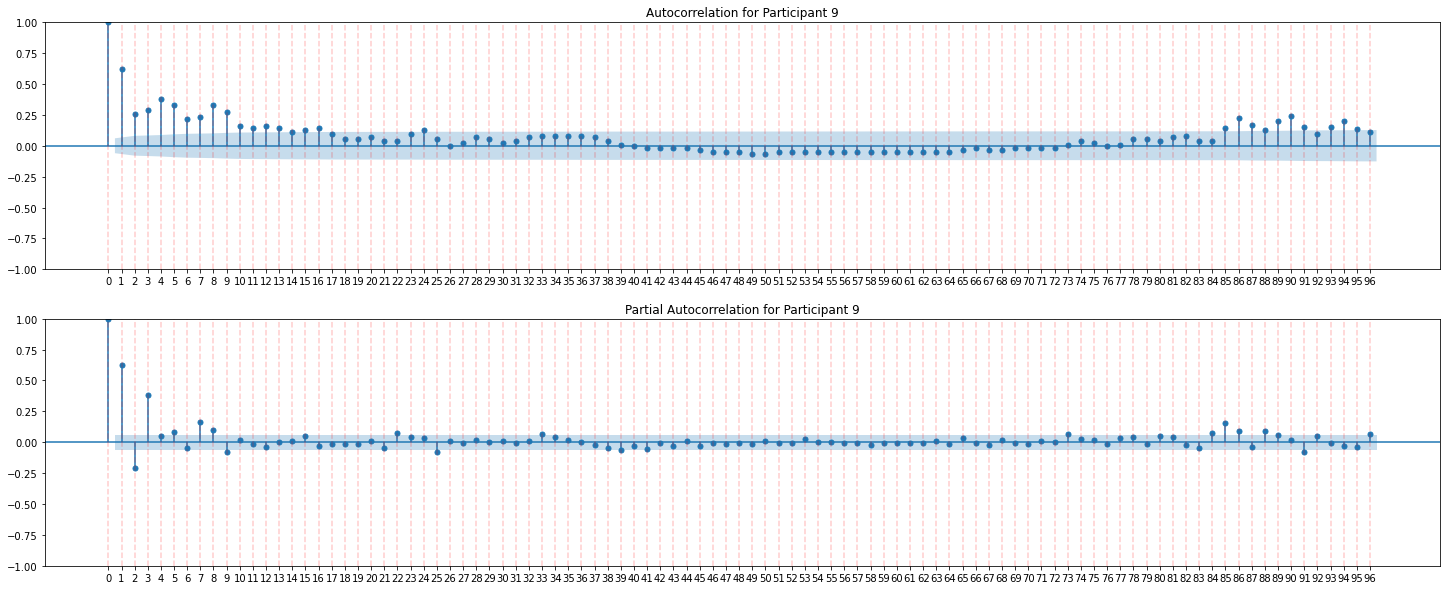

stationary


/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


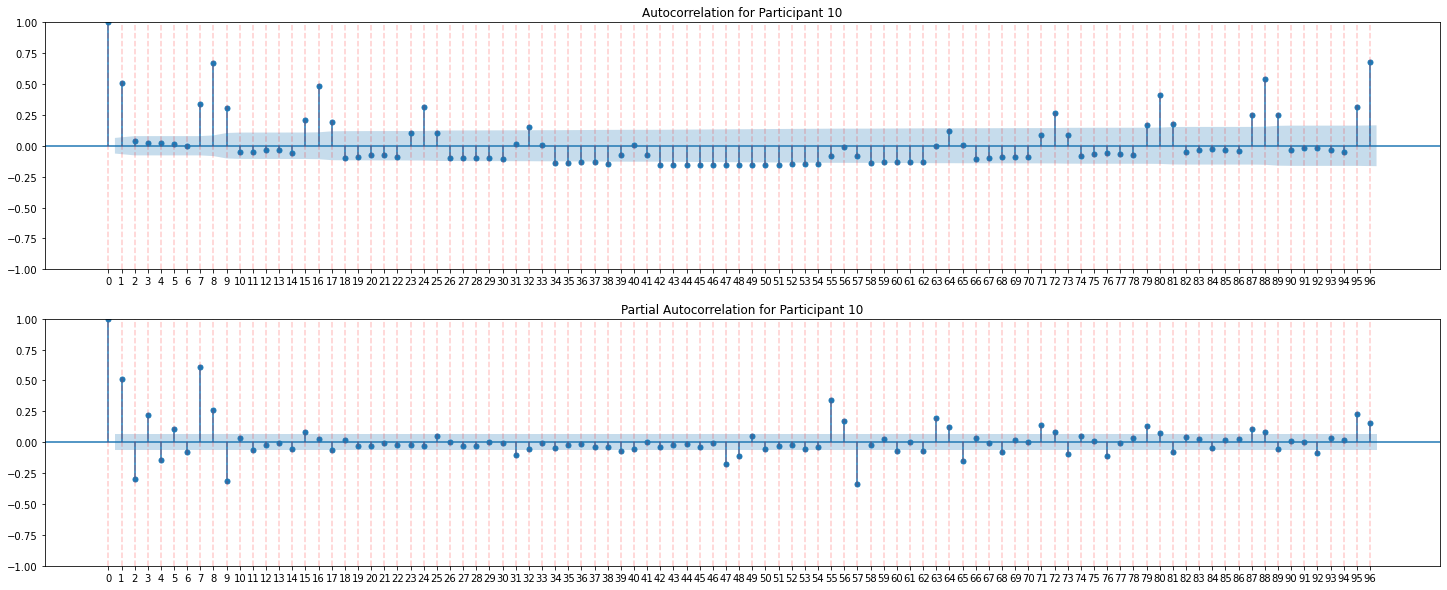

In [473]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa import stattools as sts

def plot_autocorrelation(dataset, user):
    lags = 96

    result = sts.adfuller(dataset.wearing_off)
    is_stationary = result[1] < 0.05
    if is_stationary:
        print("stationary")
        tmp = dataset.wearing_off
    else:
        print("not stationary")
        tmp = dataset.wearing_off.diff()
        tmp.iloc[0] = 0

    fig, (ax1, ax2) = plt.subplots(2, 1)
    plot_acf(tmp, lags=lags, use_vlines=True, ax=ax1)
    for i in range(0, lags+1):
        ax1.axvline(i, color ="red", linestyle = "--", alpha = 0.2)
    ax1.set_title(f'Autocorrelation for Participant {user}')
    ax1.set_xticks(range(0, lags+1))
    
    plot_pacf(tmp, lags=lags, use_vlines=True, ax=ax2)
    for i in range(0, lags+1):
        ax2.axvline(i, color ="red", linestyle = "--", alpha = 0.2)
    ax2.set_title(f'Partial Autocorrelation for Participant {user}')
    ax2.set_xticks(range(0, lags+1))
    
    plt.show()

for number in range(1, 11):
    dataset = load_dataset(f'participant{number}', interval)

    plot_autocorrelation(dataset, number)

# Change point detection

## Sample

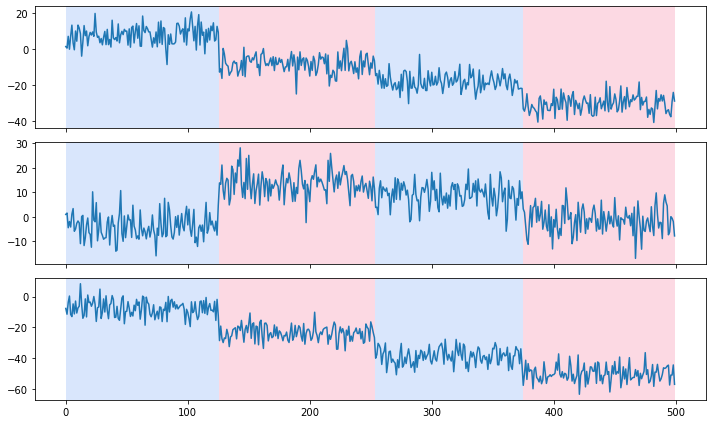

In [281]:
import numpy as np
import matplotlib.pylab as plt
import ruptures as rpt

signal, bkps = rpt.pw_constant(
    n_samples=500, n_features=3, n_bkps=3,
    noise_std=5.0, delta=(1,20)
)
rpt.display(signal, bkps)
plt.show()

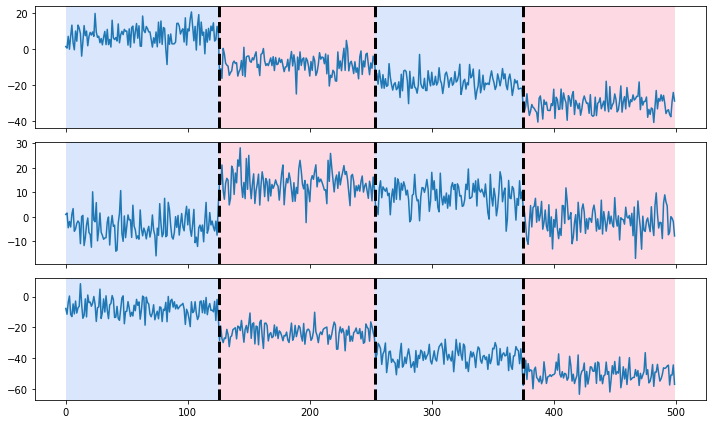

In [282]:
algo = rpt.Pelt(model="rbf", jump=1, min_size=2).fit(signal)
penalty_value = 1 # beta
bkps_pred = algo.predict(pen=penalty_value)

rpt.show.display(signal, bkps, bkps_pred)
plt.show()

## Wearing-off dataset

In [295]:
wo_bkps = list(dataset.reset_index().query("wearing_off == 1").index)
print(wo_bkps)

[124, 125, 132, 133, 140, 141, 148, 149, 156, 157, 164, 165, 220, 221, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 236, 237, 244, 245, 252, 253, 260, 261, 316, 317, 332, 333, 334, 335, 336, 340, 341, 342, 343, 344, 348, 349, 356, 357, 412, 413, 420, 421, 428, 429, 436, 437, 444, 445, 452, 453, 508, 509, 516, 517, 524, 525, 532, 533, 540, 541, 548, 549, 604, 605, 612, 613, 616, 617, 618, 619, 620, 621, 628, 629, 636, 637, 644, 645, 700, 701, 708, 709, 716, 717, 720, 724, 725, 732, 733, 740, 741, 796, 797, 804, 805, 812, 813, 820, 821, 826, 827, 828, 829, 836, 837, 892, 893, 900, 901, 908, 909, 916, 917, 924, 925, 932, 933]


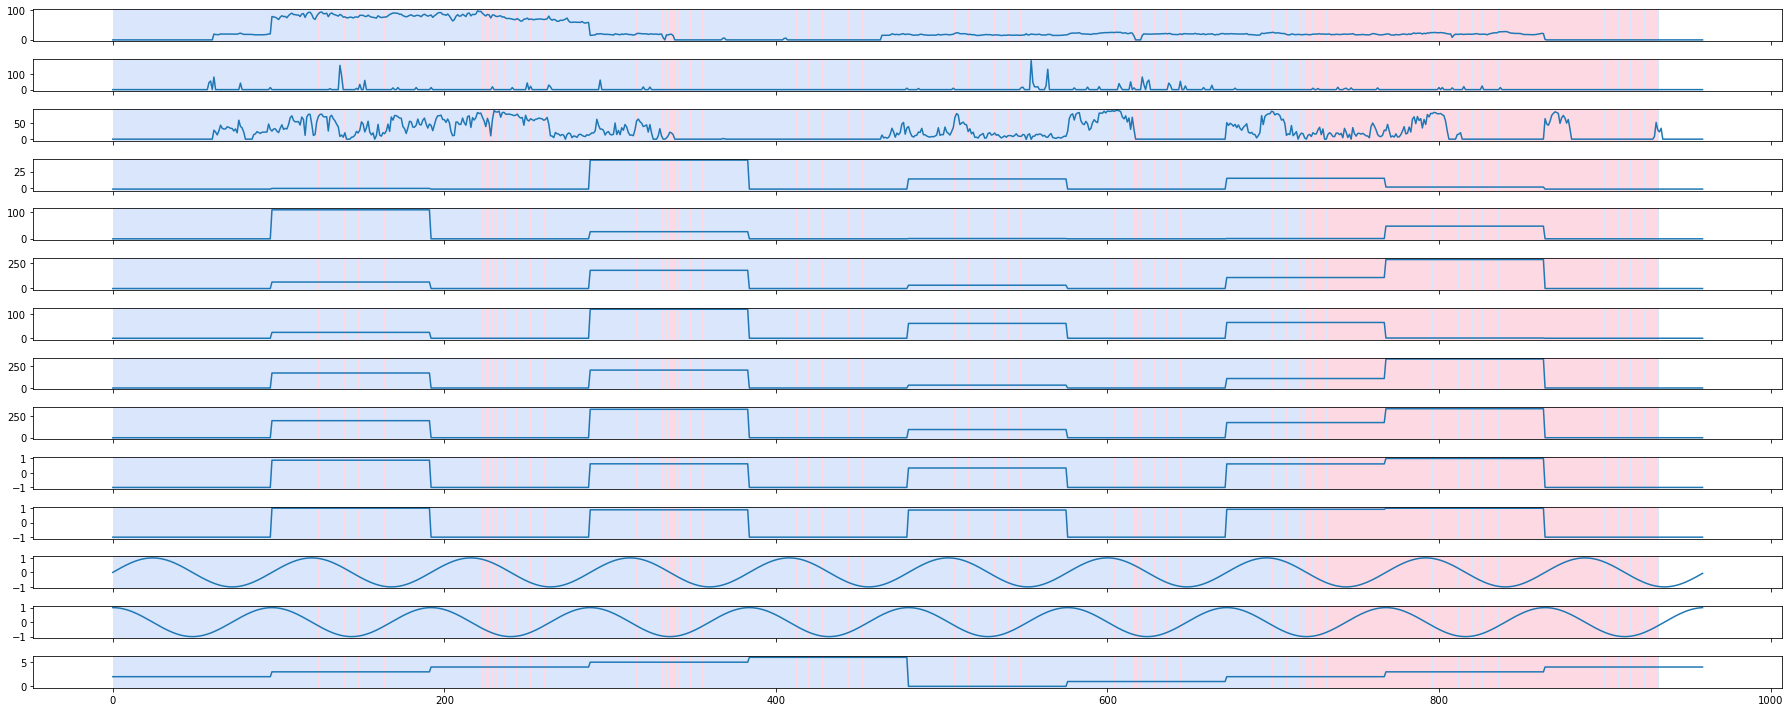

In [380]:
rpt.display(dataset.iloc[:, 0:-1], wo_bkps, figsize=(25,10))
plt.show()

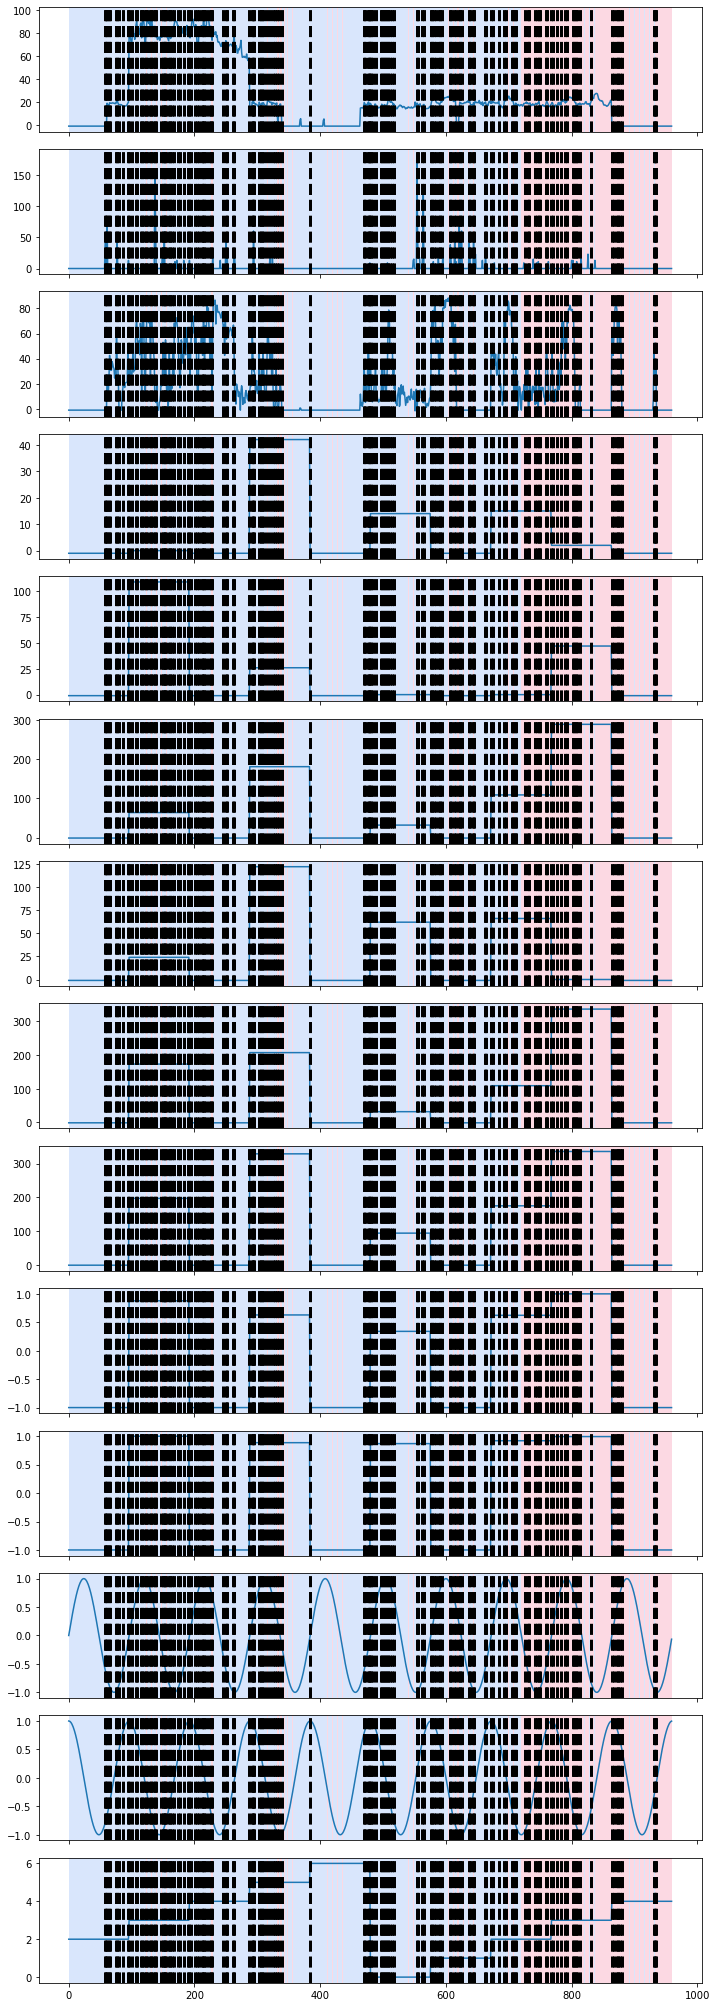

In [466]:
algo = rpt.Pelt(model="rbf", jump=1, min_size=1).fit(dataset.iloc[:, 0:-1])
penalty_value = 0.01 # beta
bkps_pred = algo.predict(pen=penalty_value)

rpt.show.display(dataset.iloc[:, 0:-1], wo_bkps, bkps_pred)
plt.show()

In [467]:
from ruptures.metrics import precision_recall

# wo_bkps.append(max(bkps_pred))
p, r = precision_recall(wo_bkps, bkps_pred)
print((p, r))

(0.25333333333333335, 0.2992125984251969)


## Fine-tune precision-recall
* [reference](https://www.kaggle.com/code/kevinarvai/fine-tuning-a-classifier-in-scikit-learn/notebook)
* [s.o. question](https://datascience.stackexchange.com/questions/87983/selecting-a-boundary-on-a-binary-classifier-to-optimal-precision-and-recall)
* [google search](https://www.google.com/search?q=optimize+precision+recall+sklearn&client=firefox-b-d&sxsrf=ALiCzsaTpRg72UIumGz-iyXMiXcHKQ1ZwA:1658420044408&source=lnms&tbm=isch&sa=X&ved=2ahUKEwiTl4qNsIr5AhUH_WEKHQzOC8QQ_AUoAXoECAEQAw&biw=1472&bih=726&dpr=1.3#imgrc=dmC7x9hE0KDEQM)

In [464]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """
    Modified from:
    Hands-On Machine learning with Scikit-Learn
    and TensorFlow; p.89
    """
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions, "b--", label="Precision")
    plt.plot(thresholds, recalls, "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')

In [462]:
precisions = []
recalls = []
penalty_values = [0, 0.001, 0.01, 0.25, 0.5, 0.75, 1]
margins = [29, 30, 31]

for margin in margins:
    algo = rpt.Pelt(model="rbf", jump=1, min_size=1).fit(dataset.iloc[:, 0:-1])
    penalty_value = 0
    bkps_pred = algo.predict(pen=penalty_value)

    if max(wo_bkps) > max(bkps_pred):
        bkps_pred = bkps_pred.append(max(wo_bkps))
    elif max(wo_bkps) < max(bkps_pred):
        wo_bkps = wo_bkps.append(max(bkps_pred))

    p, r = precision_recall(wo_bkps, bkps_pred, margin=margin)
    precisions.append(p)
    recalls.append(r)

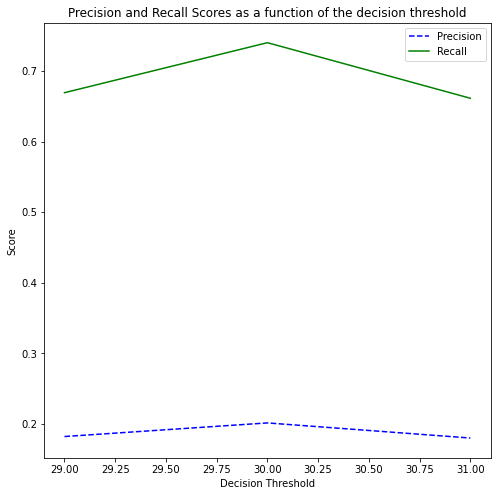

In [463]:
plot_precision_recall_vs_threshold(precisions, recalls, margins)